# Pre-requisites

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import shutil

# Autosave

In [2]:
def autosave_file(file_path, archive_folder="_archived"):    
    # Get the current timestamp
    timeID = datetime.now().strftime("%y%m%d-%H%M")
    
    # Get the file name and extension
    file_name = os.path.basename(file_path)
    file_name_without_ext, file_ext = os.path.splitext(file_name)
    main_file_name = file_name_without_ext.split("_main")[0]
    
    # Create the new file name with timestamp
    new_file_name = f"{main_file_name}_{timeID}{file_ext}"
    new_file_path = os.path.join(archive_folder, new_file_name)
    
    # Copy the file to the archive folder with the new name
    # shutil.copy(file_path, new_file_path)
    shutil.copy(file_path, new_file_path)
    
    print(f"File saved to {new_file_path}")

In [3]:
# Autosave
file_path = "analysis_main.ipynb"
autosave_file(file_path)

File saved to _archived\analysis_250117-1048.ipynb


# Explore the data 

In [4]:
# Sample mass
sample_mass = {'500907_1': 1.3e-3,
               '500907_2': 1.2e-3,
               '501023_1': 1.2e-3,
               '501023_2': 1.7e-3,
               '501024_1': 2.0e-3,} # [g]

In [ ]:
# Define the path to the Data folder
data_folder = '../data'

# Initialize an empty dictionary to store the dataframes
data_dict = {}

# Loop through all files in the Data folder
for filename in os.listdir(data_folder):
    if filename.endswith('.csv'):
        # Create the full file path
        file_path = os.path.join(data_folder, filename)
        
        # Get the file name without the extension
        file_name_without_ext = os.path.splitext(filename)[0]
        
        # Read the CSV file into a dataframe
        df = pd.read_csv(file_path)
        
        # Drop columns with all NaN values
        df.dropna(axis=1, how='all', inplace=True)
        
        # Drop rows with all NaN values
        df.dropna(axis=0, how='all', inplace=True)
        
        # Store the dataframe in the dictionary with the filename as the key
        data_dict[file_name_without_ext] = df

# Print the keys of the dictionary to verify
print(data_dict.keys())

dict_keys(['500907_1', '500907_2', '501023_1', '501023_2', '501024_1'])


In [6]:
for i in data_dict:
    print(i)
    print(data_dict[i].info())
    print('\n')

500907_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310508 entries, 0 to 310507
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Time                    310508 non-null  float64
 1   Unsubtracted Heat Flow  310508 non-null  float64
 2   Baseline Heat Flow      310508 non-null  float64
 3   Program Temperature     310508 non-null  float64
 4   Sample Temperature      310508 non-null  float64
 5   Approx. Gas Flow        310508 non-null  float64
 6   Heat Flow Calibration   310508 non-null  float64
 7   Uncorrected Heat Flow   310508 non-null  float64
 8                           310508 non-null  object 
dtypes: float64(8), object(1)
memory usage: 21.3+ MB
None


500907_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310508 entries, 0 to 310507
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  


In [7]:
for i in data_dict:
    df = data_dict[i]
    
    # Change column names
    df.rename(columns={'Time': 't / min',
                       'Unsubtracted Heat Flow': 'Q / mW',
                       'Sample Temperature': 'T / °C',
                       'Program Temperature': 'Tp / °C'},
              inplace=True)

    # Create 't / s' column
    df['t / s'] = df['t / min'] * 60    # [s]
    
    # Create a new column for heat flow per unit of mass
    df['q / W g^-1'] = df['Q / mW'] / sample_mass[i] * 1e-3   # [W g^-1]
    
    # Delete other columns
    df.drop(columns=[col for col in df.columns if col not in ['t / s', 'q / W g^-1', 'T / °C', 'Tp / °C']], inplace=True)
    
    # Re-arrange column order
    df = df[['t / s', 'q / W g^-1', 'T / °C', 'Tp / °C']]

Plot.

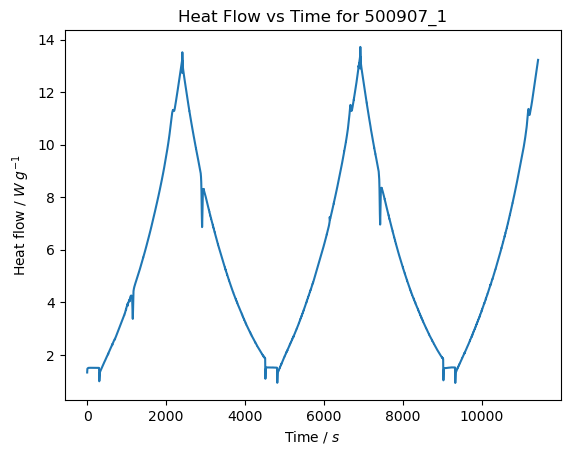

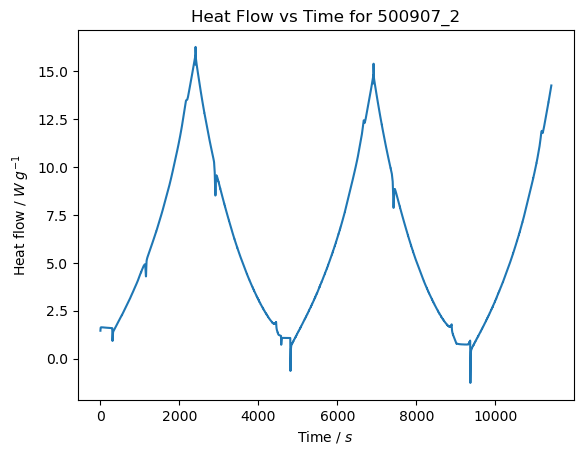

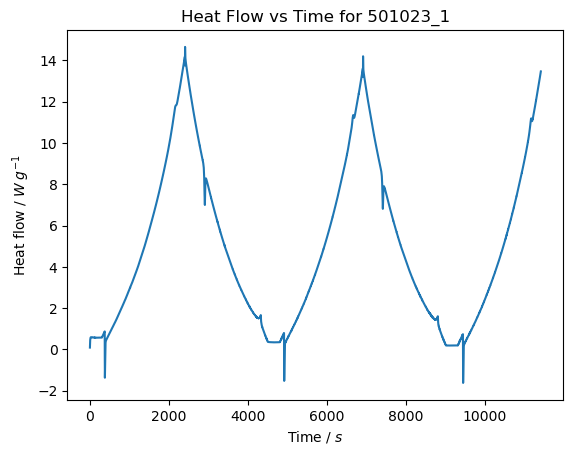

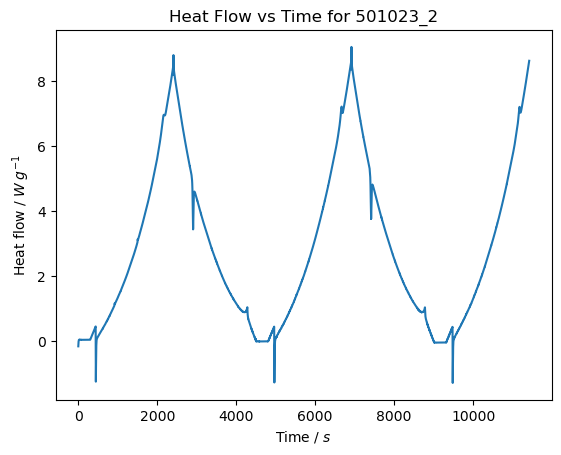

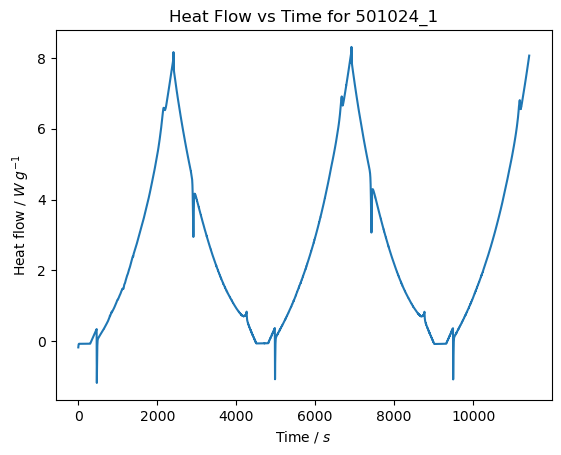

In [8]:
for key, df in data_dict.items():
    plt.figure()
    plt.plot(df['t / s'], df['q / W g^-1'])
    plt.title(f'Heat Flow vs Time for {key}')
    plt.xlabel('Time / $s$')
    plt.ylabel(r'Heat flow / $W \; g^{-1}$')
    plt.show()

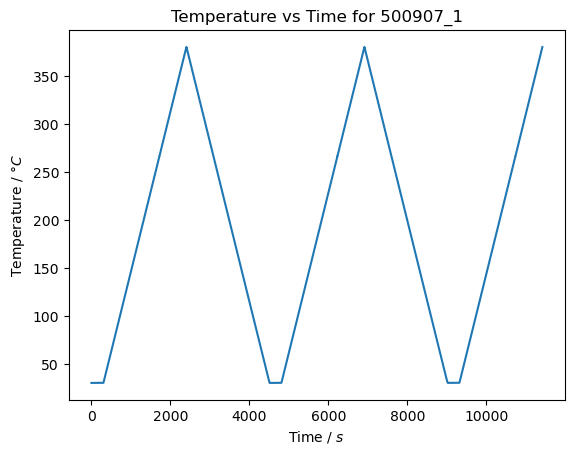

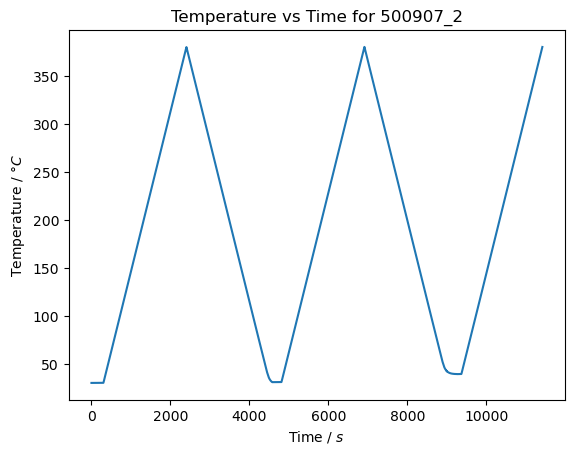

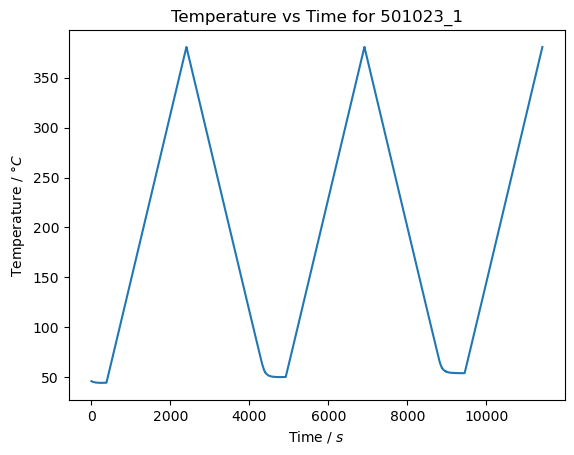

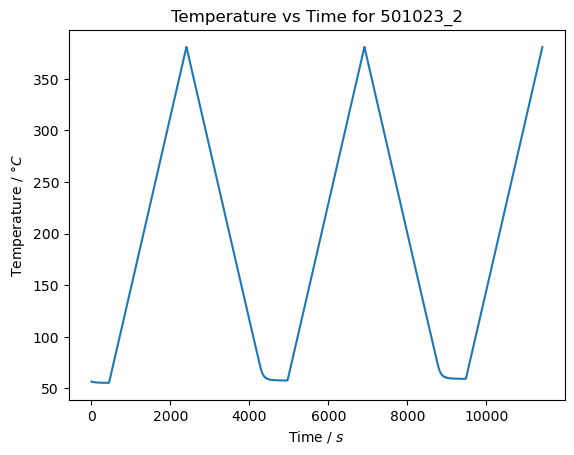

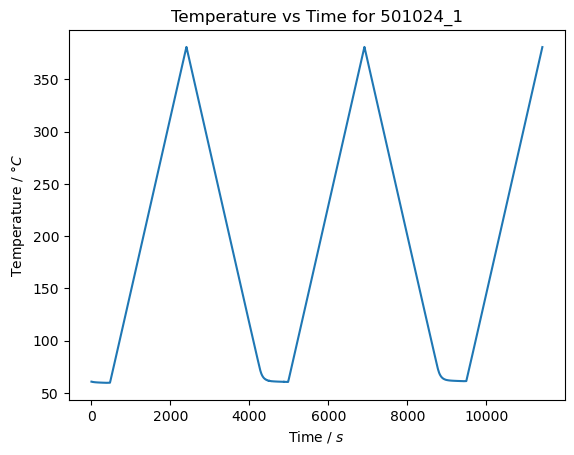

In [9]:
for key, df in data_dict.items():
    plt.figure()
    plt.plot(df['t / s'], df['T / °C'])
    plt.title(f'Temperature vs Time for {key}')
    plt.xlabel(r'Time / $s$')
    plt.ylabel('Temperature / $°C$')
    plt.show()

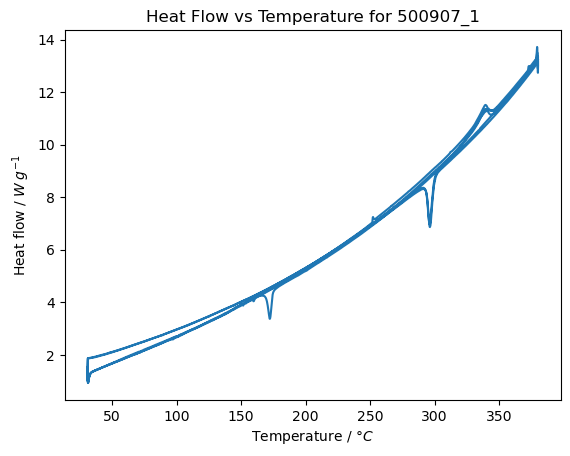

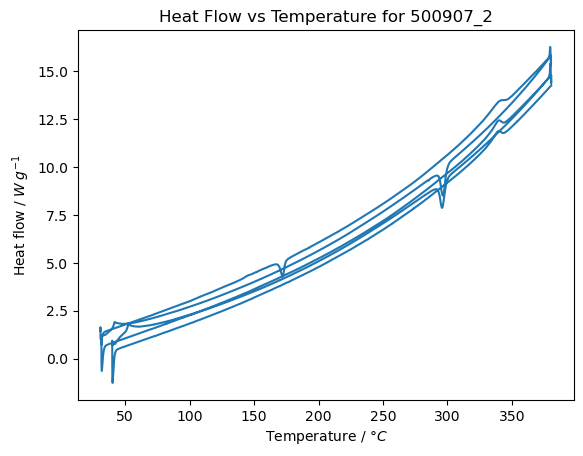

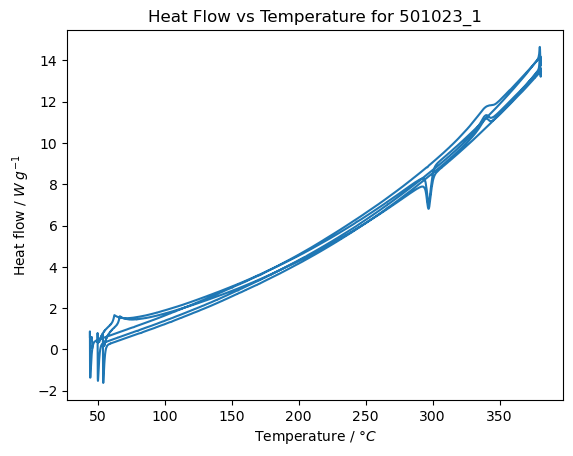

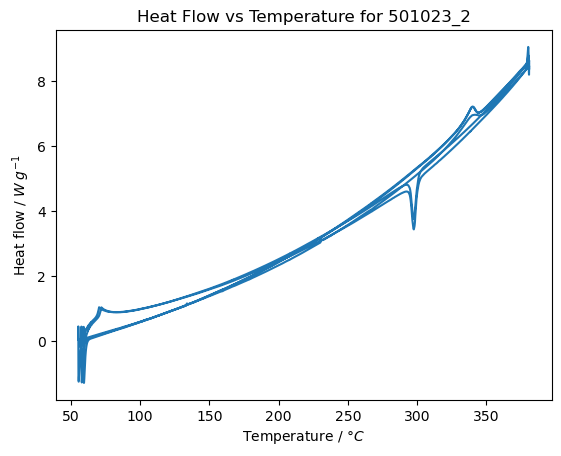

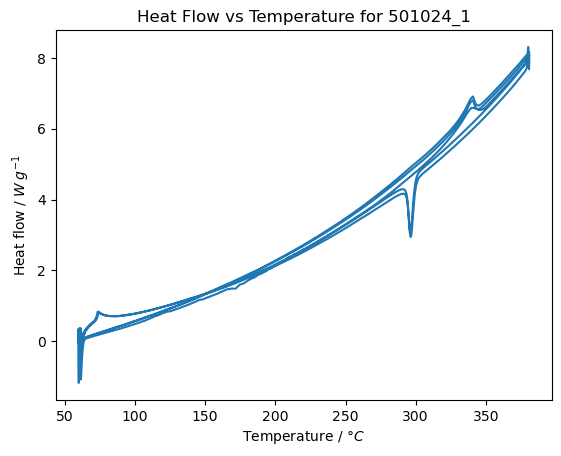

In [10]:
for key, df in data_dict.items():
    plt.figure()
    plt.plot(df['T / °C'], df['q / W g^-1'])
    plt.title(f'Heat Flow vs Temperature for {key}')
    plt.xlabel(r'Temperature / $°C$')
    plt.ylabel(r'Heat flow / $W \; g^{-1}$')
    plt.show()

# Filter heating-cooling cycles

## Cycle number

A cycle consists of:
1. Holding
2. Heating
3. Cooling

In [11]:
# Copy data_dict to create a new dictionary to store the filtered dataframes
data_dict_copied = data_dict.copy()

for key, df in data_dict_copied.items():
    # Create dTp and dT columns
    df['dTp'] = df['Tp / °C'] - df['Tp / °C'].shift(1)  # current - previous
    df['dT'] = df['T / °C'] - df['T / °C'].shift(1)  # current - previous
    
    # Find the maximum and minimum program temperature
    max_temp = df['Tp / °C'].max()
    min_temp = df['Tp / °C'].min()
    
    # Find the index where Program Temperature returns to its minimum after reaching the maximum
    # cycle_start_indices = df[(df['Tp / °C'] == min_temp) & (df['Tp / °C'].shift(1) > min_temp)].index # shift(1) refers to previous row
    cycle_start_indices = df[(df['dTp'].shift(1) < 0) & (df['dTp'] == 0)].index

    # Add 0 to the beginning of the cycle_start_indices list
    cycle_start_indices = cycle_start_indices.insert(0, 0)

    # Create a new column 'Cycle No' in the dataframe
    df['Cycle No'] = np.nan

    # Add the cycle number to the 'Cycle No' column
    for i in range(len(cycle_start_indices)):
        current_cycle_no = i + 1
        
        if i == 0:
            cycle_start_index = 0
        else:
            cycle_start_index = cycle_start_indices[i]
        
        # Add no of cycles to the 'Cycle No' column
        if i != len(cycle_start_indices) - 1:
            df.loc[cycle_start_indices[i]:cycle_start_indices[i+1], 'Cycle No'] = current_cycle_no
            
        else:
            df.loc[cycle_start_indices[i]:, 'Cycle No'] = current_cycle_no

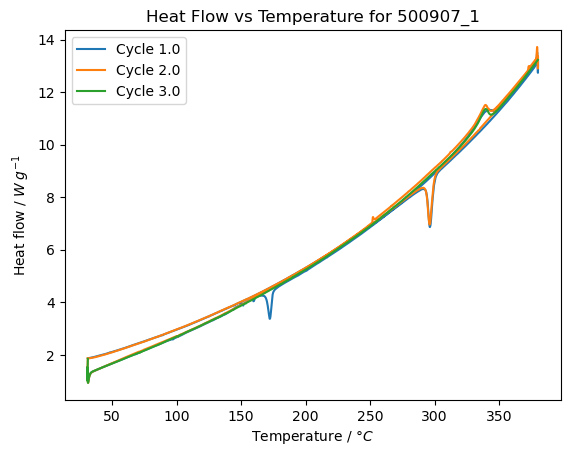

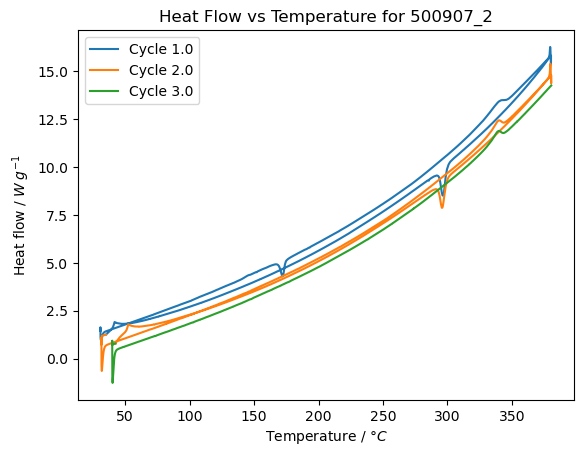

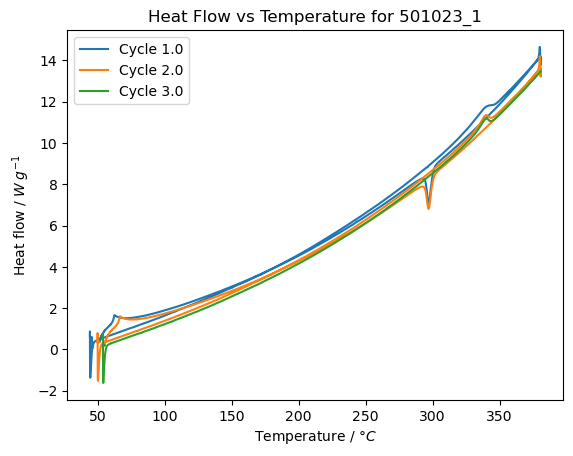

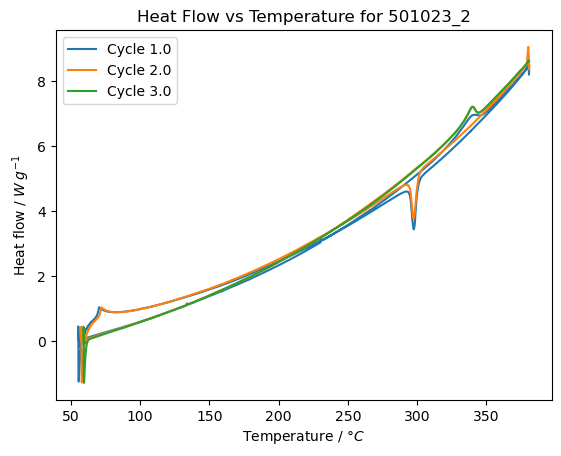

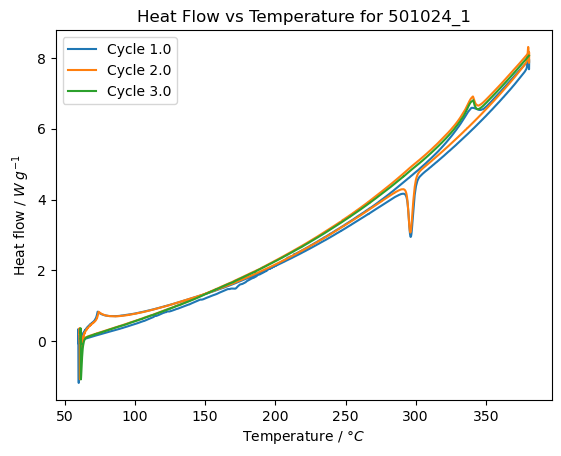

In [12]:
# Plot the Heat Flow vs Temperature for each cycle
for key, df in data_dict_copied.items():
    # Get unique cycle numbers
    unique_cycles = df['Cycle No'].unique()
    
    # Plot all cycles in the same figure
    plt.figure()
    
    for cycle_no in unique_cycles:
        current_cycle_df = df[df['Cycle No'] == cycle_no]
        plt.plot(current_cycle_df['T / °C'], current_cycle_df['q / W g^-1'], label=f'Cycle {cycle_no}')
    
    plt.title(f'Heat Flow vs Temperature for {key}')
    plt.xlabel(r'Temperature / $°C$')
    plt.ylabel(r'Heat flow / $W \; g^{-1}$')
    plt.legend()
    plt.show()

## Heating, cooling and holding in each cycle

In [13]:
for key, df in data_dict_copied.items():
    # Create dQ column
    df['dTp'] = df['Tp / °C'] - df['Tp / °C'].shift(1)
    
    # Create new column 'Heating/Cooling/Holding' to be used for string later
    df['Heating/Cooling/Holding'] = ''

    # Get unique values of 'Cycle No'
    unique_cycle_no = df['Cycle No'].unique()

    for i in unique_cycle_no:
        # Filter dataframe by 'Cycle No'
        current_df = df[df['Cycle No'] == i]
        
        # Find the maximum and minimum program temperature
        max_temp = current_df['Tp / °C'].max()
        min_temp = current_df['Tp / °C'].min()
        
        # Set 'Heating/Cooling/Holding' to 'Heating' where 'dQ' is positive
        current_df.loc[(current_df['Tp / °C'] < max_temp) & (current_df['dTp'] > 0), 'Heating/Cooling/Holding'] = 'Heating'
        current_df.loc[(current_df['Tp / °C'] > min_temp) & (current_df['dTp'] < 0), 'Heating/Cooling/Holding'] = 'Cooling'
        current_df.loc[current_df['dTp'] == 0, 'Heating/Cooling/Holding'] = 'Holding'

        # Update the original DataFrame with the modified current_df
        df.loc[df['Cycle No'] == i, :] = current_df # Use .loc to update the original DataFrame in memory

Plot.

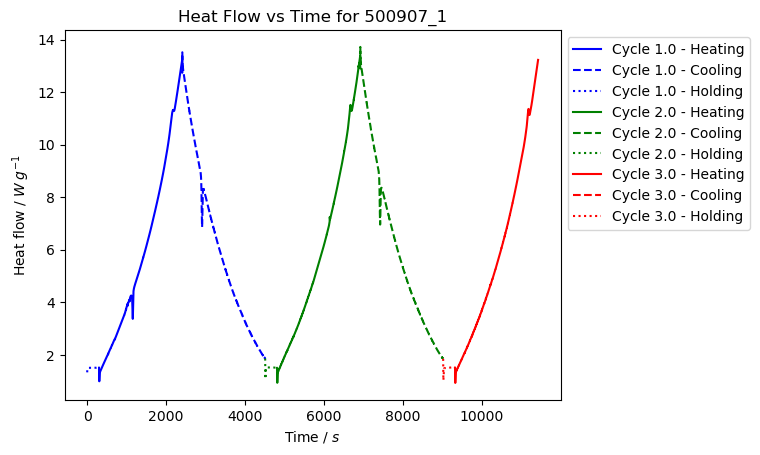

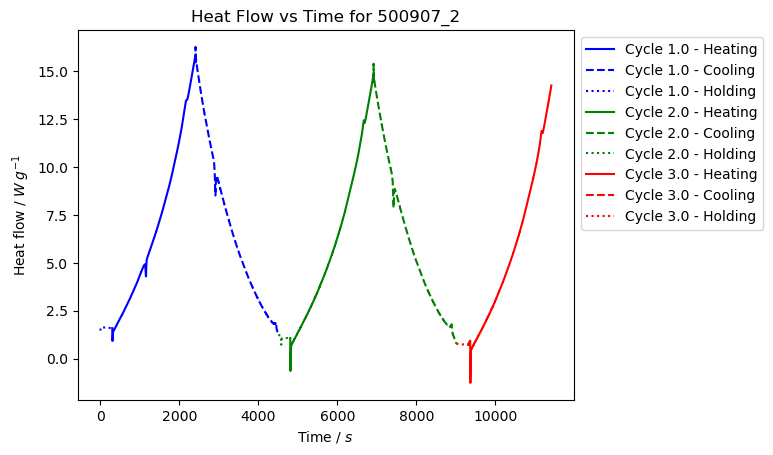

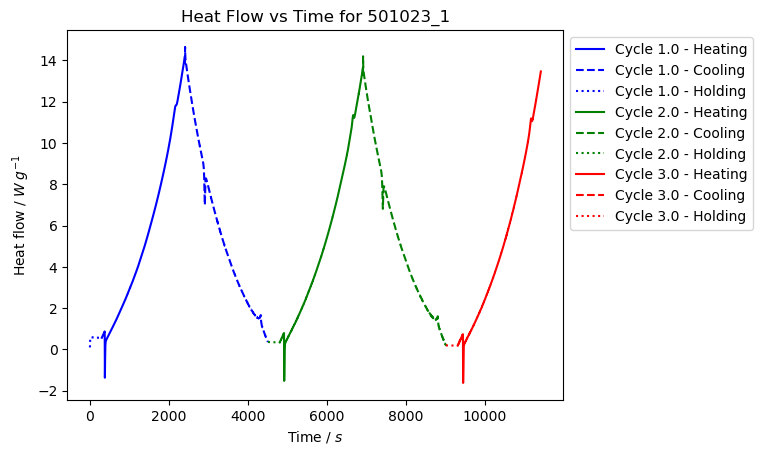

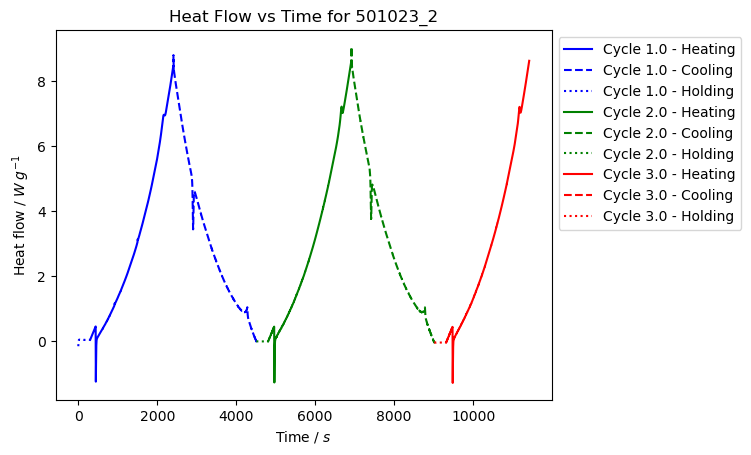

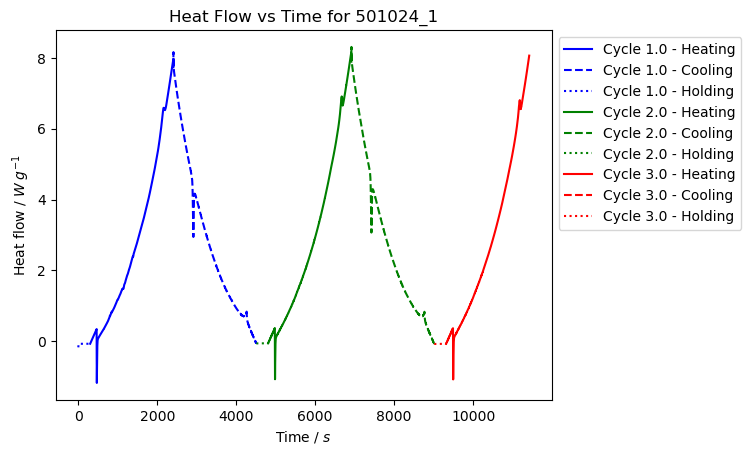

In [14]:
# Define line styles for Heating and Cooling
line_styles = {'Heating': '-', 'Cooling': '--', 'Holding': ':'}

# Define colors for each cycle number
colors = {1: 'b', 2: 'g', 3: 'r'}

for key, df in data_dict_copied.items():
    unique_cycles = df['Cycle No'].unique()
    
    plt.figure()
    
    for cycle_no in unique_cycles:
        current_cycle_df = df[df['Cycle No'] == cycle_no]
        
        for heating_cooling in ['Heating', 'Cooling', 'Holding']:
            subset_df = current_cycle_df[current_cycle_df['Heating/Cooling/Holding'] == heating_cooling]
            plt.plot(subset_df['t / s'], subset_df['q / W g^-1'], 
                     linestyle=line_styles[heating_cooling], 
                     color=colors[cycle_no], 
                     label=f'Cycle {cycle_no} - {heating_cooling}')
    
    plt.title(f'Heat Flow vs Time for {key}')
    plt.xlabel(r'Time / $s$')
    plt.ylabel(r'Heat flow / $W \; g^{-1}$')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

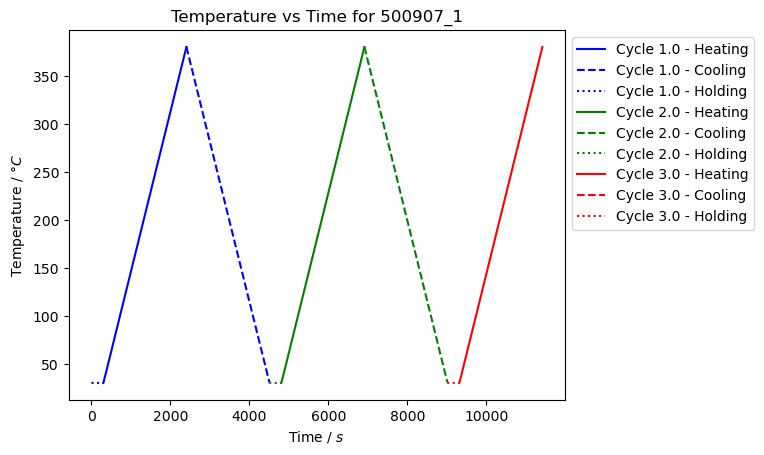

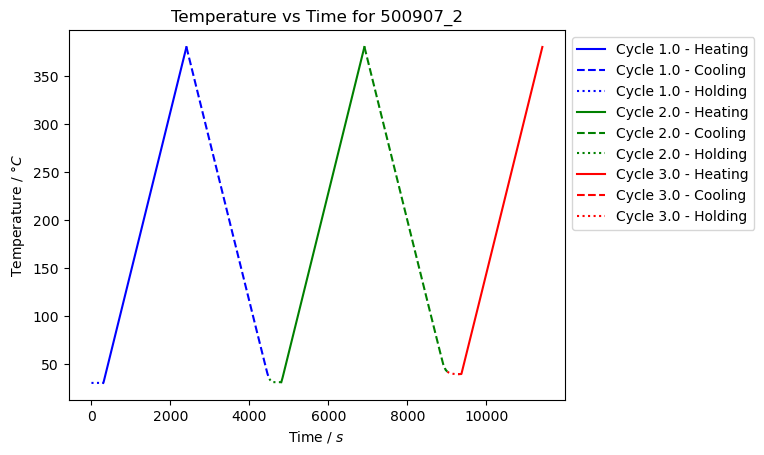

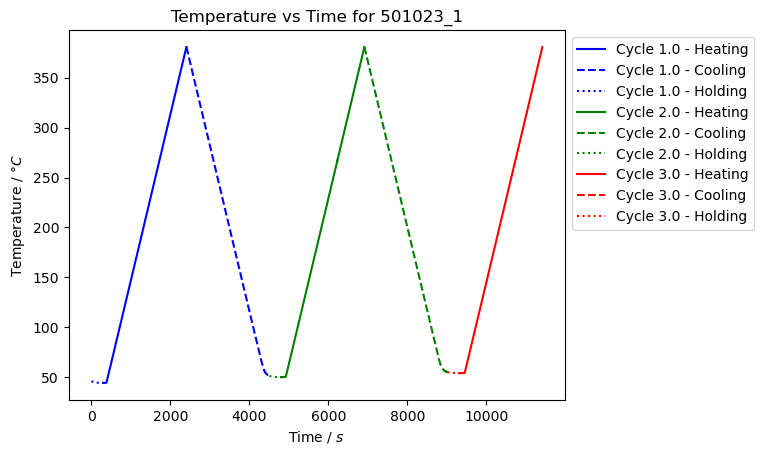

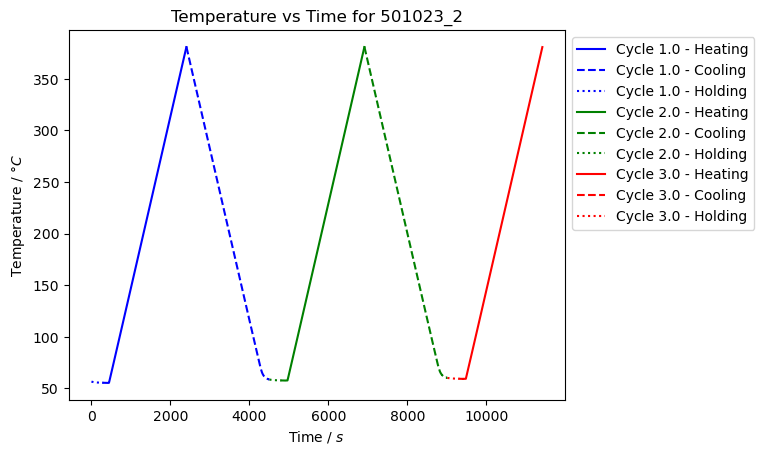

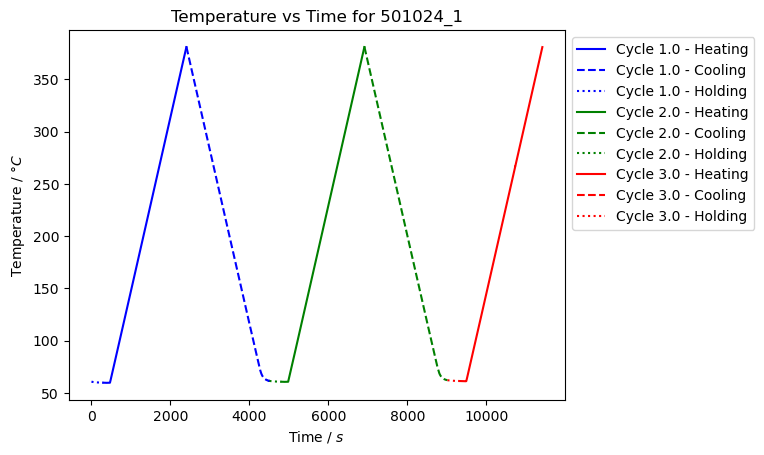

In [15]:
# Define line styles for Heating and Cooling
line_styles = {'Heating': '-', 'Cooling': '--', 'Holding': ':'}

# Define colors for each cycle number
colors = {1: 'b', 2: 'g', 3: 'r'}

for key, df in data_dict_copied.items():
    unique_cycles = df['Cycle No'].unique()
    
    plt.figure()
    
    for cycle_no in unique_cycles:
        current_cycle_df = df[df['Cycle No'] == cycle_no]
        
        for heating_cooling in ['Heating', 'Cooling', 'Holding']:
            subset_df = current_cycle_df[current_cycle_df['Heating/Cooling/Holding'] == heating_cooling]
            plt.plot(subset_df['t / s'], subset_df['T / °C'], 
                     linestyle=line_styles[heating_cooling], 
                     color=colors[cycle_no], 
                     label=f'Cycle {cycle_no} - {heating_cooling}')
    
    plt.title(f'Temperature vs Time for {key}')
    plt.xlabel(r'Time / $s$')
    plt.ylabel(r'Temperature / $°C$')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

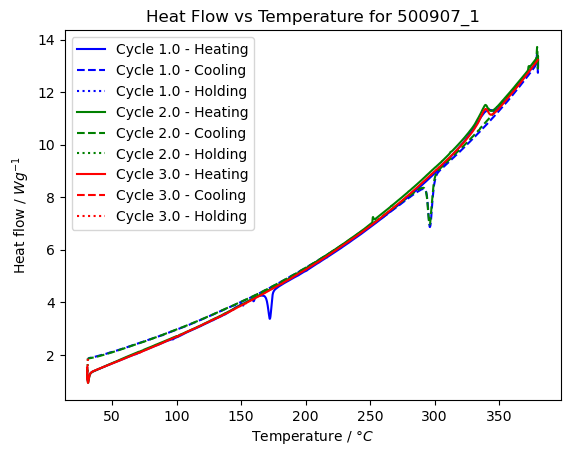

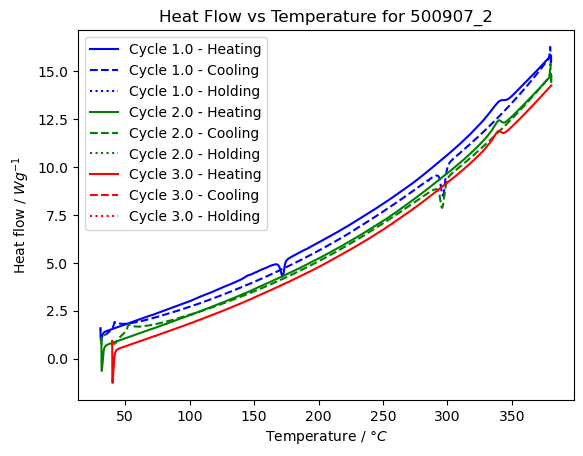

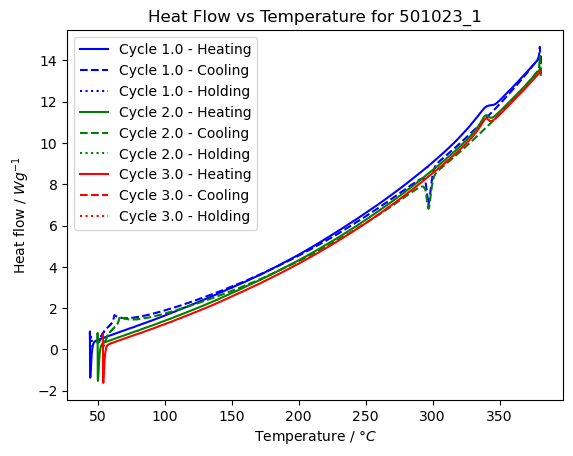

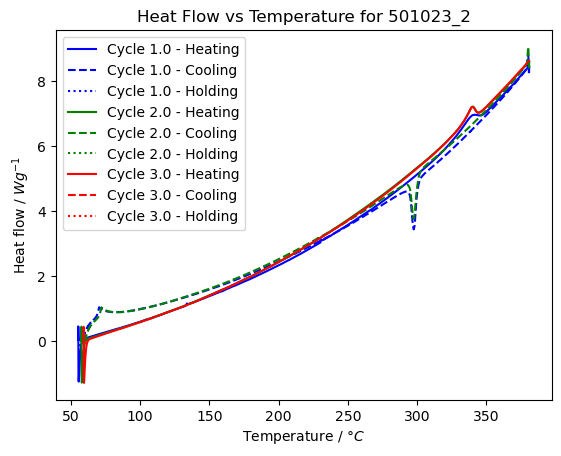

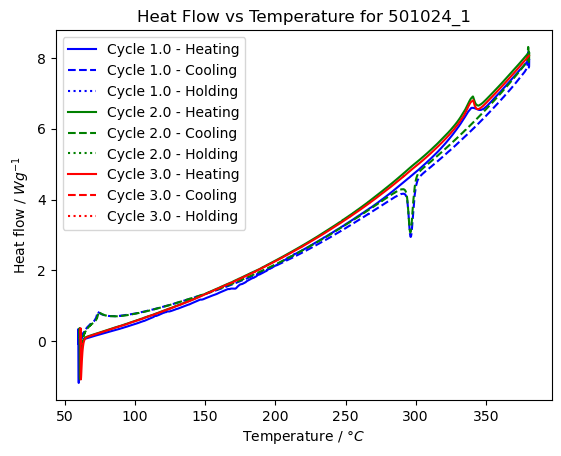

In [16]:
# Define line styles for Heating, Cooling, and Holding
line_styles = {'Heating': '-', 'Cooling': '--', 'Holding': ':'}

# Define colors for each cycle number
colors = {1: 'b', 2: 'g', 3: 'r'}

for key, df in data_dict_copied.items():
    unique_cycles = df['Cycle No'].unique()
    
    plt.figure()
    
    for cycle_no in unique_cycles:
        current_cycle_df = df[df['Cycle No'] == cycle_no]
        
        for heating_cooling in ['Heating', 'Cooling', 'Holding']:
            subset_df = current_cycle_df[current_cycle_df['Heating/Cooling/Holding'] == heating_cooling]
            plt.plot(subset_df['T / °C'], subset_df['q / W g^-1'], 
                     linestyle=line_styles[heating_cooling], 
                     color=colors[cycle_no], 
                     label=f'Cycle {cycle_no} - {heating_cooling}')
    
    plt.title(f'Heat Flow vs Temperature for {key}')
    plt.xlabel(r'Temperature / $°C$')
    plt.ylabel(r'Heat flow / $W g^{-1}$')
    plt.legend()
    plt.show()

## Plot heat flow vs temperature

## First cycle

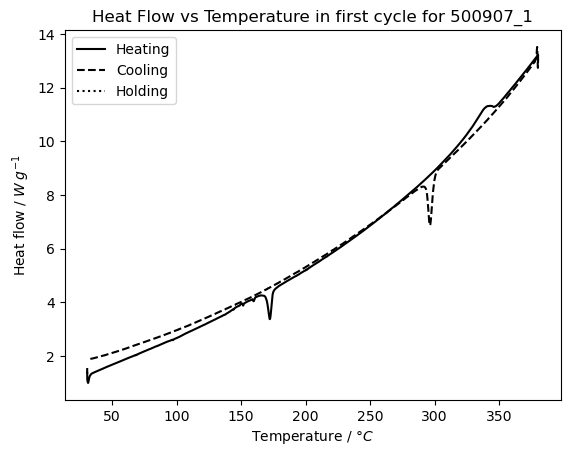

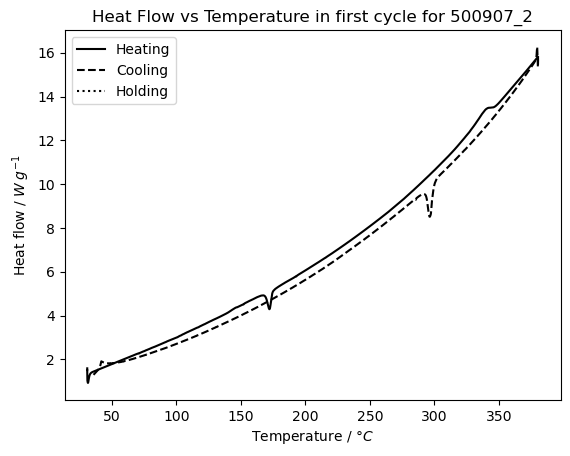

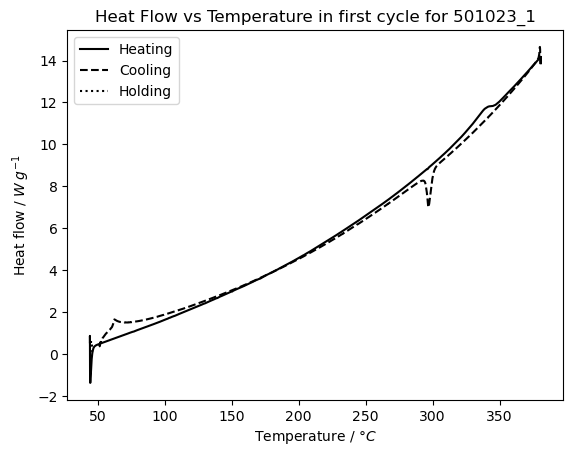

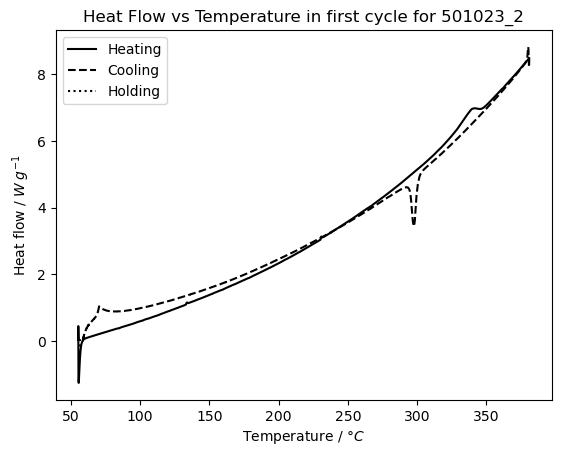

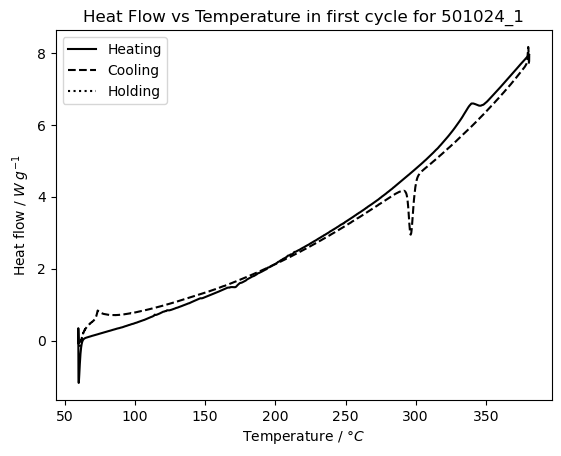

In [17]:
# Define line styles for Heating, Cooling, and Holding
line_styles = {'Heating': '-', 'Cooling': '--', 'Holding': ':'}

for key, df in data_dict_copied.items():
    # Filter first heating cycle
    current_cycle_df = df[df['Cycle No'] == 1]
    
    # Plot
    plt.figure()
    for heating_cooling in ['Heating', 'Cooling', 'Holding']:
        subset_df = current_cycle_df[current_cycle_df['Heating/Cooling/Holding'] == heating_cooling]
        plt.plot(subset_df['T / °C'], subset_df['q / W g^-1'], 
                 linestyle=line_styles[heating_cooling], 
                 color='black', 
                 label=f'{heating_cooling}')

    plt.title(f'Heat Flow vs Temperature in first cycle for {key}')
    plt.xlabel(r'Temperature / $°C$')
    plt.ylabel(r'Heat flow / $W \; g^{-1}$')
    plt.legend()
    plt.show()

## Second cycle

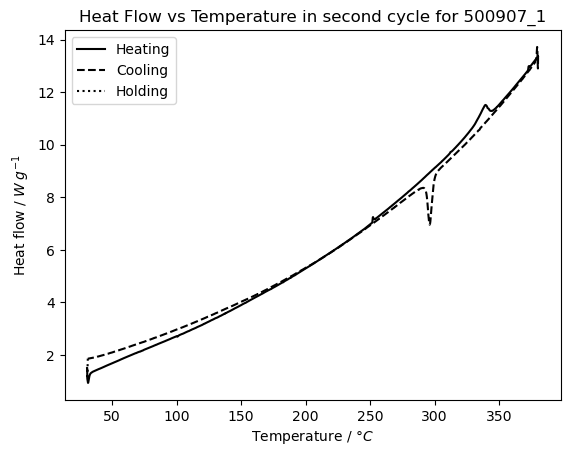

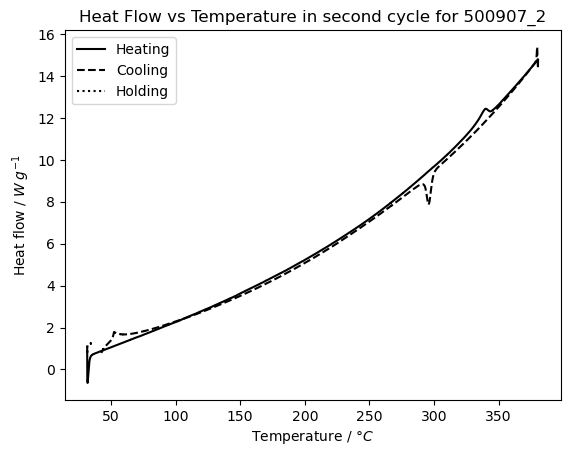

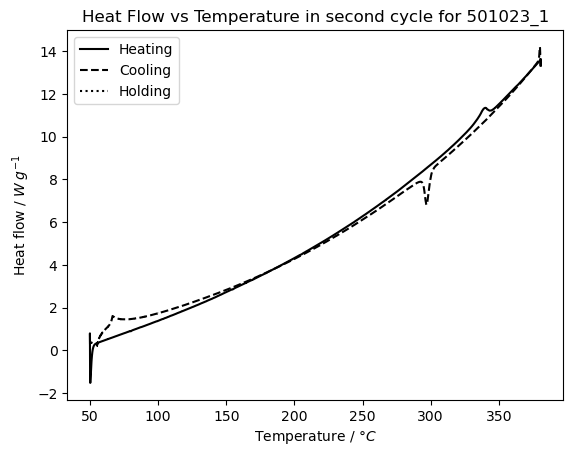

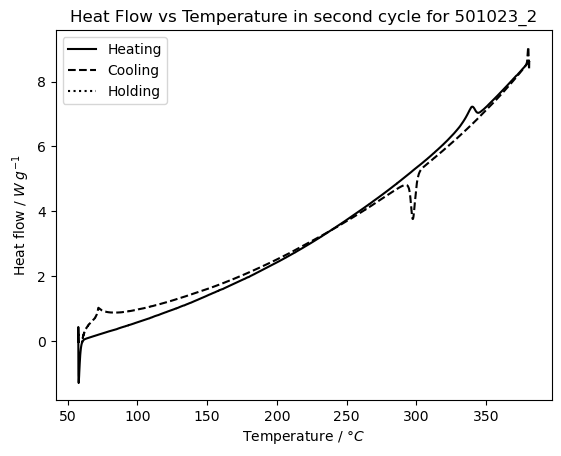

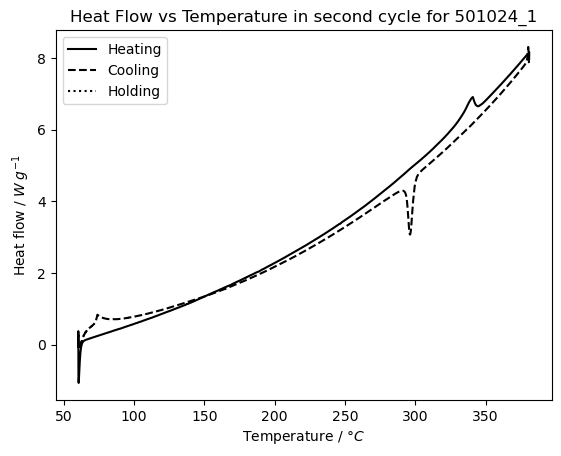

In [18]:
# Define line styles for Heating, Cooling, and Holding
line_styles = {'Heating': '-', 'Cooling': '--', 'Holding': ':'}

for key, df in data_dict_copied.items():
    # Filter first heating cycle
    current_cycle_df = df[df['Cycle No'] == 2]  # Second cycle
    
    # Plot
    plt.figure()
    for heating_cooling in ['Heating', 'Cooling', 'Holding']:
        subset_df = current_cycle_df[current_cycle_df['Heating/Cooling/Holding'] == heating_cooling]
        plt.plot(subset_df['T / °C'], subset_df['q / W g^-1'], 
                 linestyle=line_styles[heating_cooling], 
                 color='black', 
                 label=f'{heating_cooling}')

    plt.title(f'Heat Flow vs Temperature in second cycle for {key}')
    plt.xlabel(r'Temperature / $°C$')
    plt.ylabel(r'Heat flow / $W \; g^{-1}$')
    plt.legend()
    plt.show()

## Third cycle

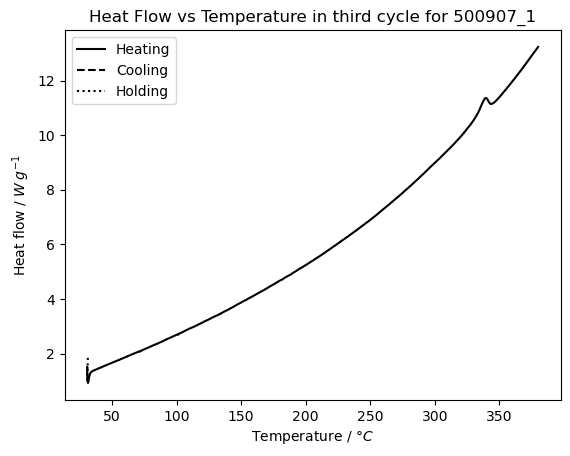

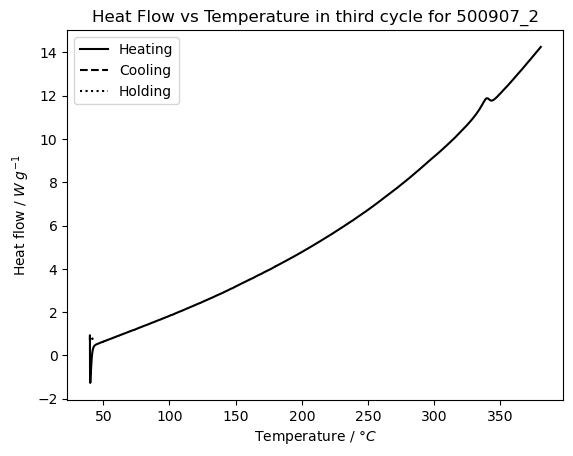

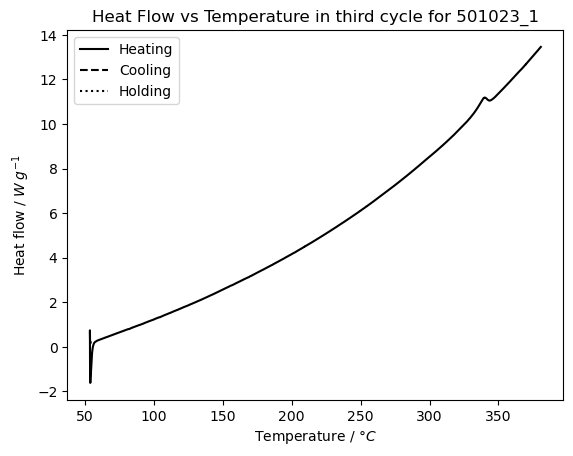

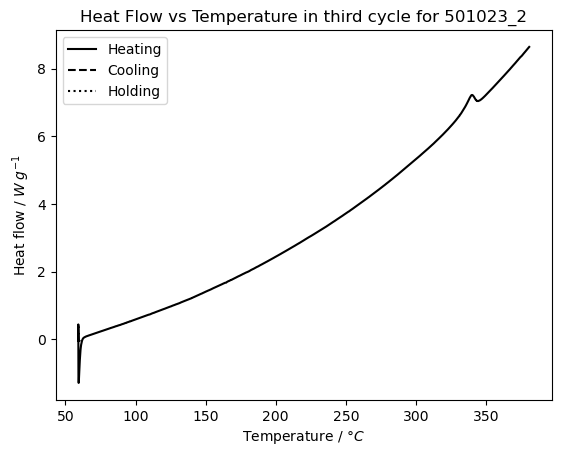

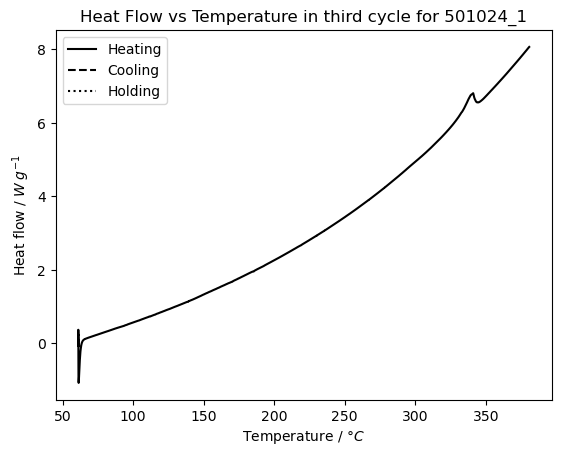

In [19]:
for key, df in data_dict_copied.items():
    # Filter first heating cycle
    current_cycle_df = df[df['Cycle No'] == 3]  # Third cycle
    
    # Plot
    plt.figure()
    for heating_cooling in ['Heating', 'Cooling', 'Holding']:
        subset_df = current_cycle_df[current_cycle_df['Heating/Cooling/Holding'] == heating_cooling]
        plt.plot(subset_df['T / °C'], subset_df['q / W g^-1'], 
                 linestyle=line_styles[heating_cooling], 
                 color='black', 
                 label=f'{heating_cooling}')

    plt.title(f'Heat Flow vs Temperature in third cycle for {key}')
    plt.xlabel(r'Temperature / $°C$')
    plt.ylabel(r'Heat flow / $W \; g^{-1}$')
    plt.legend()
    plt.show()

# Calculate CF

## Baseline correction

### Calculations

In [20]:
def baseline_correction(df, lower_temp_range=(290, 300), upper_temp_range=(350, 360)):
    # mask
    mask = ((df['T / °C'] >= lower_temp_range[0]) & (df['T / °C'] <= lower_temp_range[1])) | \
            ((df['T / °C'] >= upper_temp_range[0]) & (df['T / °C'] <= upper_temp_range[1]))
    
    # Extract baseline points within the specified temperature range    
    baseline_points = df.loc[mask]
    
    # Choose every 10th point in baseline_points to filter out the noise
    baseline_points = baseline_points.iloc[::10]
    
    # Fit a polynomial to the baseline points
    coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)
    spline = np.poly1d(coefficients)
    
    # New mask for continuous data from the beginning to the end of the baseline points
    new_mask = (df['T / °C'] >= lower_temp_range[0]) & (df['T / °C'] <= upper_temp_range[1])
    
    # Subtract the spline baseline from the heat flow data
    df.loc[new_mask, 'q_bl / W g^-1'] = spline(df.loc[new_mask, 'T / °C'])
    df['q - q_bl / W g^-1'] = df['q / W g^-1'] - df['q_bl / W g^-1']
    
    return df

In [21]:
data_dict_copied2 = data_dict_copied.copy()
data_dict_heating = {}

for key, df in data_dict_copied2.items():
    # Add an empty column for baseline-corrected heat flow
    df['q_bl / W g^-1'] = np.nan
    df['q - q_bl / W g^-1'] = np.nan
    
    # Filter for heating data only
    heating_df = df[df['Heating/Cooling/Holding'] == 'Heating']
    data_dict_heating[key] = heating_df

In [22]:
# Apply baseline correction to the heating data for each cycle
for key, df in data_dict_heating.items():
    for cycle_no in df['Cycle No'].unique():
        current_cycle_df = df[df['Cycle No'] == cycle_no]        
        current_cycle_df = baseline_correction(current_cycle_df)
        df.loc[df['Cycle No'] == cycle_no, :] = current_cycle_df


C:\Users\sieun\AppData\Local\Temp\ipykernel_18332\2335238094.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['q - q_bl / W g^-1'] = df['q / W g^-1'] - df['q_bl / W g^-1']
C:\Users\sieun\AppData\Local\Temp\ipykernel_18332\2335238094.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['q - q_bl / W g^-1'] = df['q / W g^-1'] - df['q_bl / W g^-1']
C:\Users\sieun\AppData\Local\Temp\ipykernel_18332\2335238094.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

### Plot Heat flow vs. Temperature

In [23]:
# Define line styles for Heating, Cooling, and Holding
line_styles = {'Heating': '-', 'Cooling': '--', 'Holding': ':'}

#### First cycle

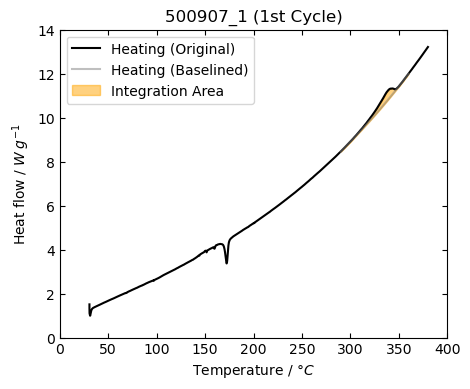

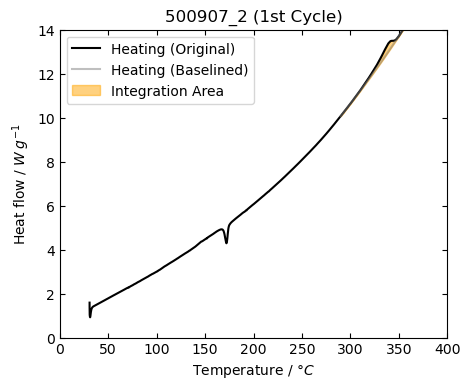

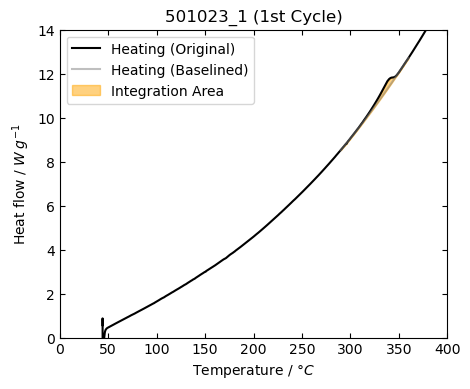

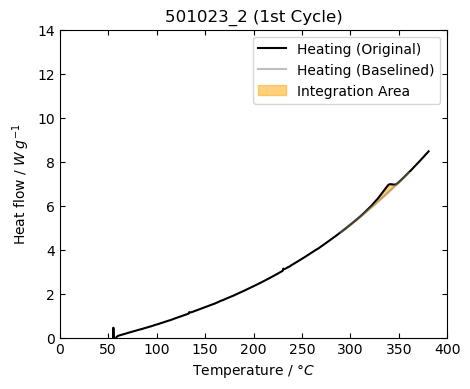

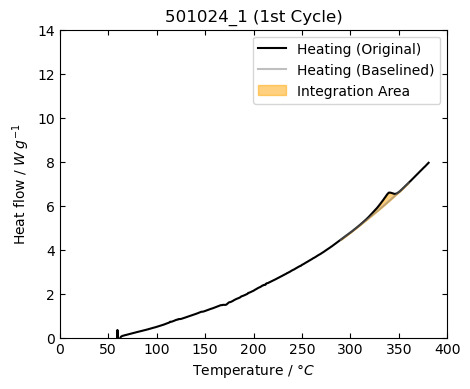

In [24]:
for key, df in data_dict_heating.items():
    # Filter for the 1st cycle only
    current_cycle_df = df[df['Cycle No'] == 1]  # First cycle
    
    plt.figure(figsize=(5, 4))
    
    for heating_cooling in current_cycle_df['Heating/Cooling/Holding'].unique():
        subset_df = current_cycle_df[current_cycle_df['Heating/Cooling/Holding'] == heating_cooling]
        
        # Plot original heat flow
        plt.plot(subset_df['T / °C'], subset_df['q / W g^-1'], 
                 linestyle=line_styles[heating_cooling], 
                 color='black', 
                 label=f'{heating_cooling} (Original)')
        
        # Plot baselined heat flow
        plt.plot(subset_df['T / °C'], subset_df['q_bl / W g^-1'], 
                 linestyle=line_styles[heating_cooling], 
                 color='gray', 
                 alpha=0.5, 
                 label=f'{heating_cooling} (Baselined)')

        # Shade the area between the baseline and Heat Flow
        plt.fill_between(subset_df['T / °C'], subset_df['q_bl / W g^-1'], subset_df['q / W g^-1'], 
                         alpha=0.5, color='orange', label='Integration Area')
    
    plt.title(f'{key} (1st Cycle)')
    plt.xlabel(r'Temperature / $°C$')
    plt.ylabel(r'Heat flow / $W \; g^{-1}$')
    plt.xlim(0, 400)
    plt.ylim(0, 14)
    plt.legend()
    plt.tick_params(direction='in', top=True, right=True)    
    plt.show()


#### Second cycle

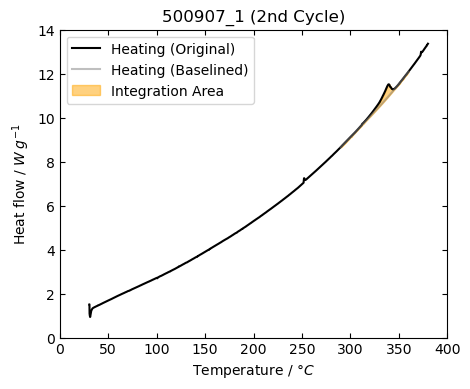

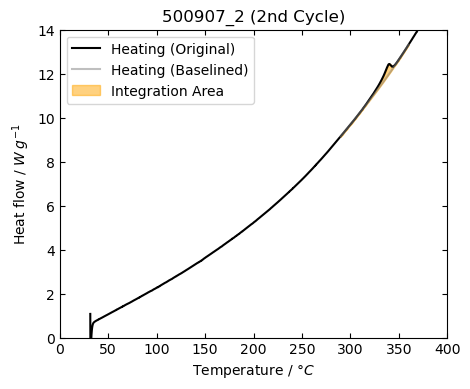

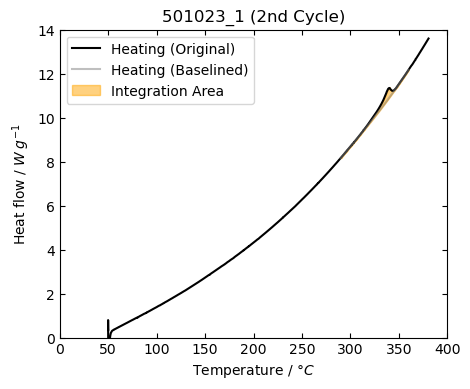

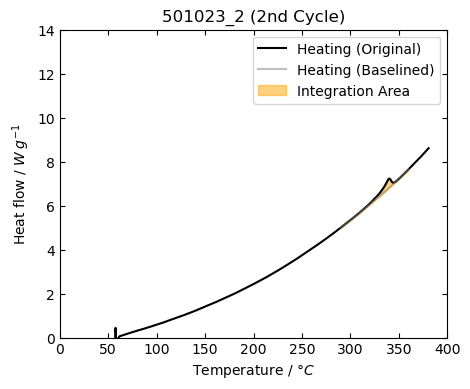

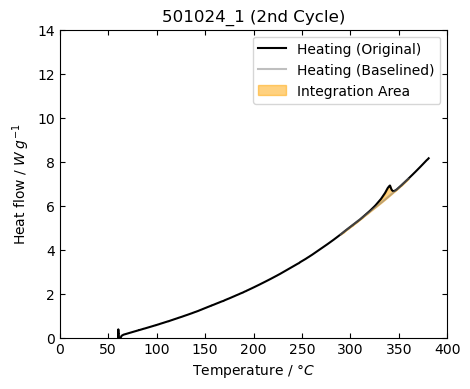

In [25]:
for key, df in data_dict_heating.items():
    # Filter for the 2nd cycle only
    current_cycle_df = df[df['Cycle No'] == 2]  # Second cycle
    
    plt.figure(figsize=(5, 4))
    
    for heating_cooling in current_cycle_df['Heating/Cooling/Holding'].unique():
        subset_df = current_cycle_df[current_cycle_df['Heating/Cooling/Holding'] == heating_cooling]
        
        # Plot original heat flow
        plt.plot(subset_df['T / °C'], subset_df['q / W g^-1'], 
                 linestyle=line_styles[heating_cooling], 
                 color='black', 
                 label=f'{heating_cooling} (Original)')
        
        # Plot baselined heat flow
        plt.plot(subset_df['T / °C'], subset_df['q_bl / W g^-1'], 
                 linestyle=line_styles[heating_cooling], 
                 color='gray', 
                 alpha=0.5, 
                 label=f'{heating_cooling} (Baselined)')
    
        # Shade the area between the baseline and Heat Flow
        plt.fill_between(subset_df['T / °C'], subset_df['q_bl / W g^-1'], subset_df['q / W g^-1'], 
                         alpha=0.5, color='orange', label='Integration Area')
    
    plt.title(f'{key} (2nd Cycle)')
    plt.xlabel(r'Temperature / $°C$')
    plt.ylabel(r'Heat flow / $W \; g^{-1}$')
    # plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlim(0, 400)
    plt.ylim(0, 14)
    plt.legend()
    plt.tick_params(direction='in', top=True, right=True)
    plt.show()


#### Thrid cycle

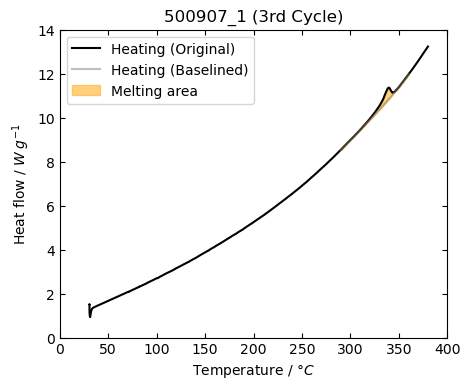

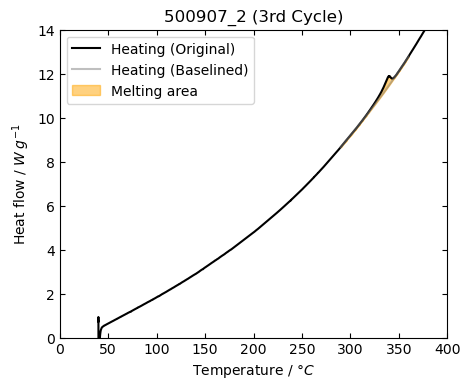

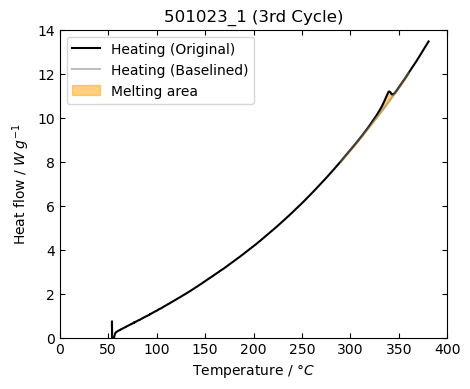

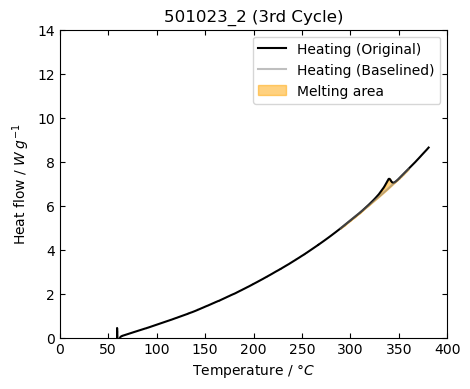

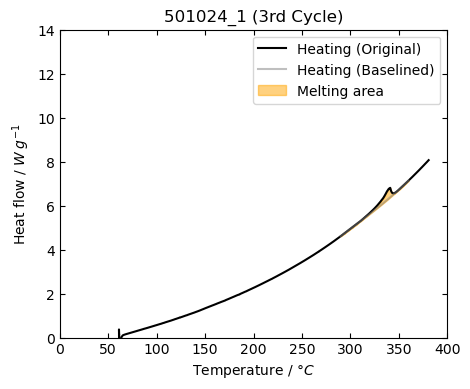

In [26]:
for key, df in data_dict_heating.items():
    # Filter for the 3rd cycle only
    current_cycle_df = df[df['Cycle No'] == 3]  # Third cycle
    
    plt.figure(figsize=(5, 4))
    
    for heating_cooling in current_cycle_df['Heating/Cooling/Holding'].unique():
        subset_df = current_cycle_df[current_cycle_df['Heating/Cooling/Holding'] == heating_cooling]
        
        # Plot original heat flow
        plt.plot(subset_df['T / °C'], subset_df['q / W g^-1'], 
                 linestyle=line_styles[heating_cooling], 
                 color='black', 
                 label=f'{heating_cooling} (Original)')
        
        # Plot baselined heat flow
        plt.plot(subset_df['T / °C'], subset_df['q_bl / W g^-1'], 
                 linestyle=line_styles[heating_cooling], 
                 color='gray', 
                 alpha=0.5, 
                 label=f'{heating_cooling} (Baselined)')
    
        # Shade the area between the baseline and Heat Flow
        plt.fill_between(subset_df['T / °C'], subset_df['q_bl / W g^-1'], subset_df['q / W g^-1'], 
                         alpha=0.5, color='orange', label='Melting area')
    
    plt.title(f'{key} (3rd Cycle)')
    plt.xlabel(r'Temperature / $°C$')
    plt.ylabel(r'Heat flow / $W \; g^{-1}$')
    # plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.legend()
    plt.xlim(0, 400)
    plt.ylim(0, 14)
    plt.tick_params(direction='in', top=True, right=True)
    plt.show()


### Plot Heat flow vs. Time

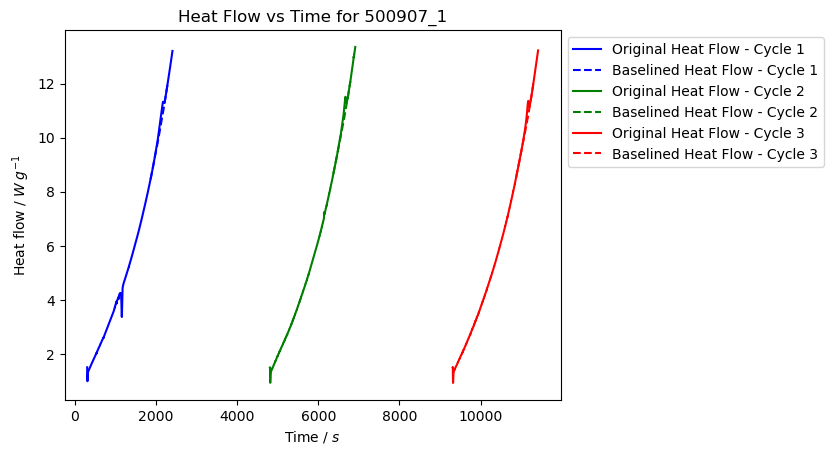

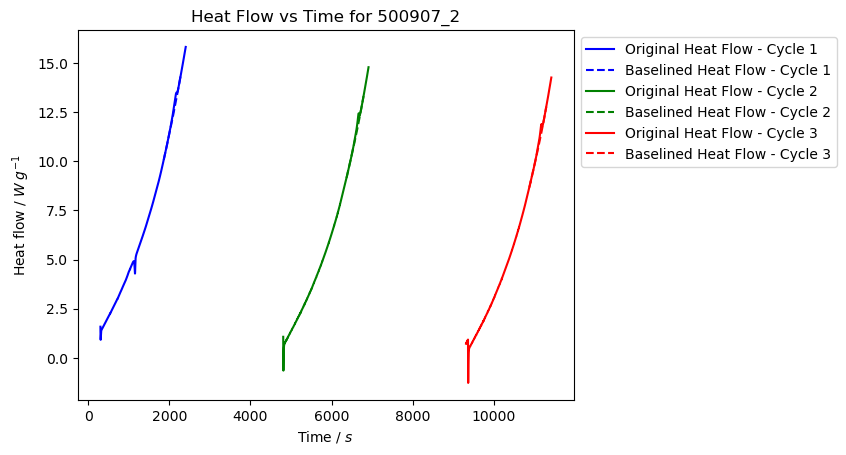

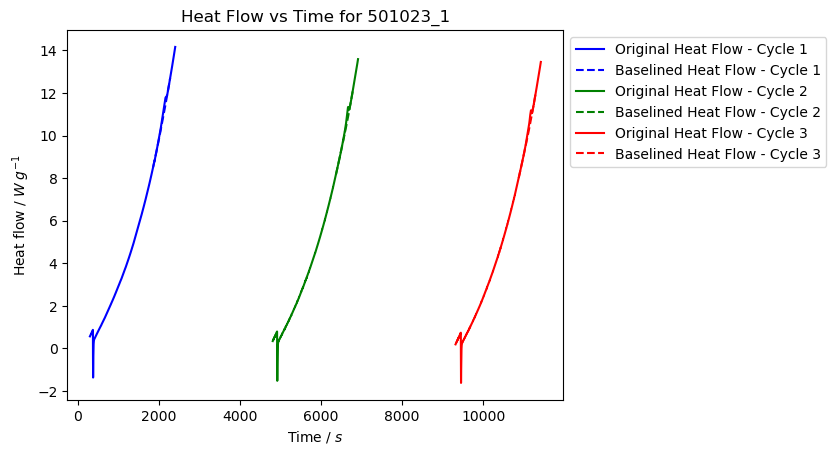

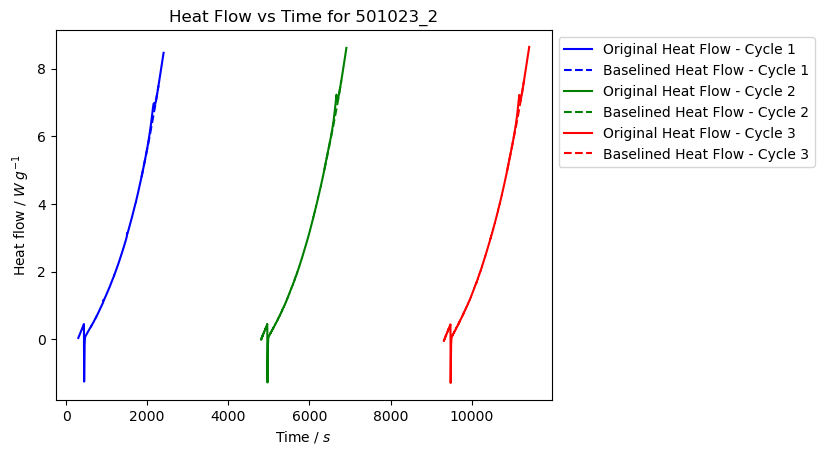

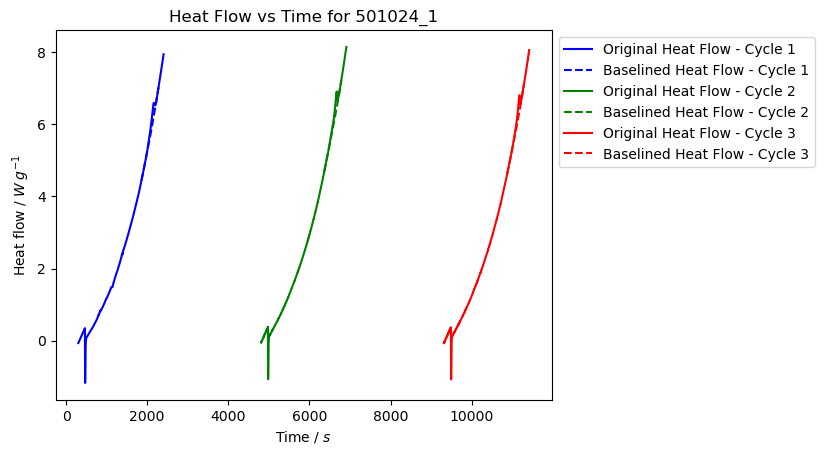

In [27]:
for key, df in data_dict_heating.items():
    plt.figure()
    
    unique_cycles = df['Cycle No'].unique()
    
    for cycle_no in unique_cycles:
        current_cycle_df = df[df['Cycle No'] == cycle_no]
        
        # Plot original heat flow
        plt.plot(current_cycle_df['t / s'], current_cycle_df['q / W g^-1'], 
                 label=f'Original Heat Flow - Cycle {int(cycle_no)}', 
                 color=colors[int(cycle_no)])
        
        # Plot baselined heat flow
        plt.plot(current_cycle_df['t / s'], current_cycle_df['q_bl / W g^-1'], 
                 label=f'Baselined Heat Flow - Cycle {int(cycle_no)}', 
                 color=colors[int(cycle_no)], linestyle='--')
    
    plt.title(f'Heat Flow vs Time for {key}')
    plt.xlabel('Time / $s$')
    plt.ylabel(r'Heat flow / $W \; g^{-1}$')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

## Integration

In [28]:
# Calculate melt enthalpy
def calculate_melt_enthalpy(df, temp_range:tuple=(290, 360)):
    # Get data between temp_range
    mask = (df['T / °C'] > temp_range[0]) & (df['T / °C'] < temp_range[1])
    df_calc = df[mask]
    
    # Integrate Heat Flow - baseline with respect to Time
    melt_enthalpy = np.trapz(df_calc['q - q_bl / W g^-1'], df_calc['t / s'])    # [J/g]
    
    return melt_enthalpy, df_calc

In [29]:
# Specify melt enthalpy of 100% crystalline PEEK
melt_enthalpy_cr = 130    # [J/g]

# Create a new DataFrame to store the results
results_df = pd.DataFrame(columns=['sample', 'cycle', 'melt enthalpy / J g^-1', 'CF / g g^-1'])

# Populate the DataFrame with the results
for key, df in data_dict_heating.items():
    for cycle_no in df['Cycle No'].unique():
        melt_enthalpy, df_calc = calculate_melt_enthalpy(df[df['Cycle No'] == cycle_no])
        cf = melt_enthalpy / melt_enthalpy_cr
        new_row = {'sample': key, 'cycle': cycle_no, 'melt enthalpy / J g^-1': melt_enthalpy, 'CF / g g^-1': cf}
        results_df.loc[len(results_df)] = new_row

# Display the results DataFrame
print(results_df)

      sample  cycle  melt enthalpy / J g^-1  CF / g g^-1
0   500907_1    1.0               46.394067     0.356877
1   500907_1    2.0               38.360647     0.295082
2   500907_1    3.0               36.732985     0.282561
3   500907_2    1.0               36.956485     0.284281
4   500907_2    2.0               31.546422     0.242665
5   500907_2    3.0               28.966641     0.222820
6   501023_1    1.0               36.044072     0.277262
7   501023_1    2.0               31.665470     0.243581
8   501023_1    3.0               31.407231     0.241594
9   501023_2    1.0               31.202189     0.240017
10  501023_2    2.0               28.102673     0.216174
11  501023_2    3.0               27.350405     0.210388
12  501024_1    1.0               37.300732     0.286929
13  501024_1    2.0               30.417628     0.233982
14  501024_1    3.0               31.211284     0.240087


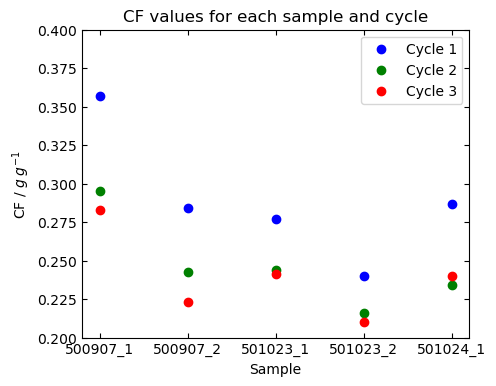

In [30]:
# Plot the CF values
plt.figure(figsize=(5, 4))

# Plot CF values for each cycle with different colors
for cycle_no in results_df['cycle'].unique():
    cycle_df = results_df[results_df['cycle'] == cycle_no]
    plt.scatter(cycle_df['sample'], cycle_df['CF / g g^-1'], 
                marker='o', color=colors[int(cycle_no)], label=f'Cycle {int(cycle_no)}')

plt.xlabel('Sample')
plt.ylabel(r'CF / $g \; g^{-1}$')
plt.title('CF values for each sample and cycle')
plt.ylim(0.20, 0.40)
plt.legend()
plt.tick_params(direction='in', top=True, right=True)
plt.show()

# Calculate CF (net)

## Baseline correction

### Calculation

In [31]:
data_dict_copied2 = data_dict_copied.copy()
data_dict_heating = {}

for key, df in data_dict_copied2.items():
    # Add an empty column for baseline-corrected heat flow
    df['q_bl / W g^-1'] = np.nan
    df['q - q_bl / W g^-1'] = np.nan
    
    # Filter for heating data only
    heating_df = df[df['Heating/Cooling/Holding'] == 'Heating']
    data_dict_heating[key] = heating_df

In [32]:
def baseline_correction(df, lower_temp_range, upper_temp_range):
    # mask
    mask = ((df['T / °C'] >= lower_temp_range[0]) & (df['T / °C'] <= lower_temp_range[1])) | \
            ((df['T / °C'] >= upper_temp_range[0]) & (df['T / °C'] <= upper_temp_range[1]))
    
    # Extract baseline points within the specified temperature range    
    baseline_points = df.loc[mask]
    
    # Choose every 10th point in baseline_points to filter out the noise
    baseline_points = baseline_points.iloc[::10]
    
    # Fit a polynomial to the baseline points
    coefficients = np.polyfit(baseline_points['T / °C'], baseline_points['q / W g^-1'], deg=3)
    spline = np.poly1d(coefficients)
    
    # New mask for continuous data from the beginning to the end of the baseline points
    new_mask = (df['T / °C'] >= lower_temp_range[0]) & (df['T / °C'] <= upper_temp_range[1])
    
    # Subtract the spline baseline from the heat flow data
    df.loc[new_mask, 'q_bl / W g^-1'] = spline(df.loc[new_mask, 'T / °C'])
    df['q - q_bl / W g^-1'] = df['q / W g^-1'] - df['q_bl / W g^-1']
    
    return df

In [33]:
# Apply baseline correction for each cycle
for key, df in data_dict_heating.items():
    for cycle_no in df['Cycle No'].unique():
        current_cycle_df = df[df['Cycle No'] == cycle_no]
        
        # Melting peak
        current_cycle_df = baseline_correction(current_cycle_df, lower_temp_range=(290, 300), upper_temp_range=(350, 360))
        df.loc[df['Cycle No'] == cycle_no, :] = current_cycle_df
        
        # Crystallization peak
        current_cycle_df = baseline_correction(current_cycle_df, lower_temp_range=(150, 160), upper_temp_range=(190, 200))
        df.loc[df['Cycle No'] == cycle_no, :] = current_cycle_df

C:\Users\sieun\AppData\Local\Temp\ipykernel_18332\2619406915.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['q - q_bl / W g^-1'] = df['q / W g^-1'] - df['q_bl / W g^-1']
C:\Users\sieun\AppData\Local\Temp\ipykernel_18332\2619406915.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['q - q_bl / W g^-1'] = df['q / W g^-1'] - df['q_bl / W g^-1']
C:\Users\sieun\AppData\Local\Temp\ipykernel_18332\2619406915.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

### Plot

In [34]:
# Define line styles for Heating, Cooling, and Holding
line_styles = {'Heating': '-', 'Cooling': '--', 'Holding': ':'}

#### First cycle

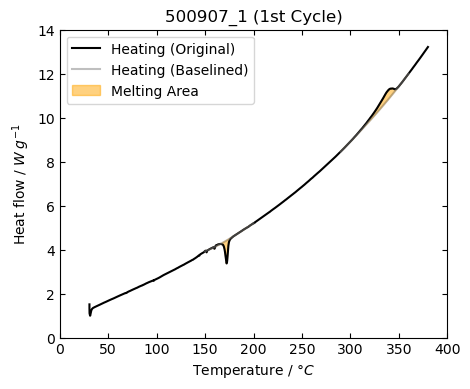

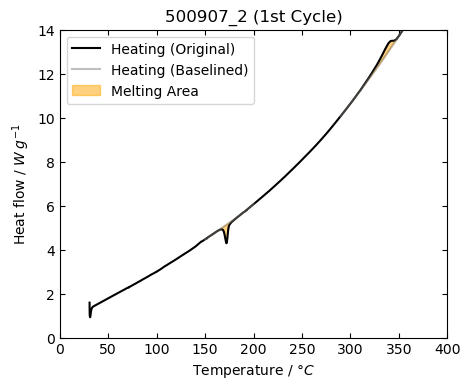

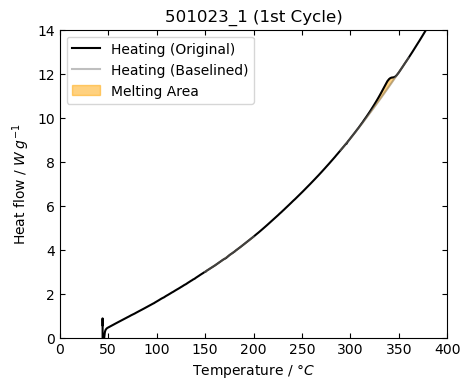

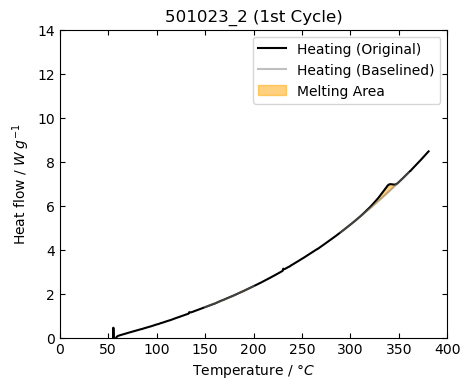

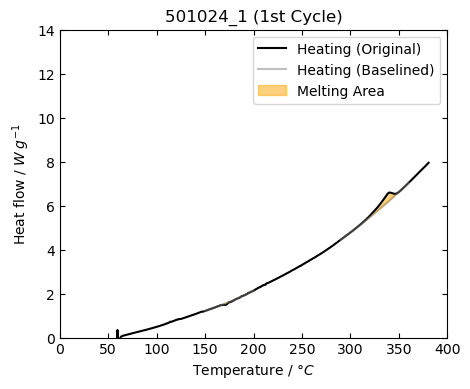

In [35]:
for key, df in data_dict_heating.items():
    # Filter for the 1st cycle only
    current_cycle_df = df[df['Cycle No'] == 1]  # First cycle
    
    plt.figure(figsize=(5 ,4))
    
    for heating_cooling in current_cycle_df['Heating/Cooling/Holding'].unique():
        subset_df = current_cycle_df[current_cycle_df['Heating/Cooling/Holding'] == heating_cooling]
        
        # Plot original heat flow
        plt.plot(subset_df['T / °C'], subset_df['q / W g^-1'], 
                 linestyle=line_styles[heating_cooling], 
                 color='black', 
                 label=f'{heating_cooling} (Original)')
        
        # Plot baselined heat flow
        plt.plot(subset_df['T / °C'], subset_df['q_bl / W g^-1'], 
                 linestyle=line_styles[heating_cooling], 
                 color='gray', 
                 alpha=0.5, 
                 label=f'{heating_cooling} (Baselined)')

        # Shade the area between the baseline and Heat Flow
        plt.fill_between(subset_df['T / °C'], subset_df['q_bl / W g^-1'], subset_df['q / W g^-1'], 
                         alpha=0.5, color='orange', label='Melting Area')
    
    plt.title(f'{key} (1st Cycle)')
    plt.xlabel(r'Temperature / $°C$')
    plt.ylabel(r'Heat flow / $W \; g^{-1}$')
    # plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlim(0, 400)
    plt.ylim(0, 14)
    plt.legend()
    plt.tick_params(direction='in', top=True, right=True)
    plt.show()

#### Second cycle

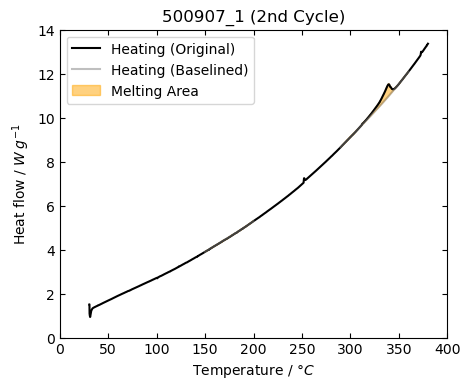

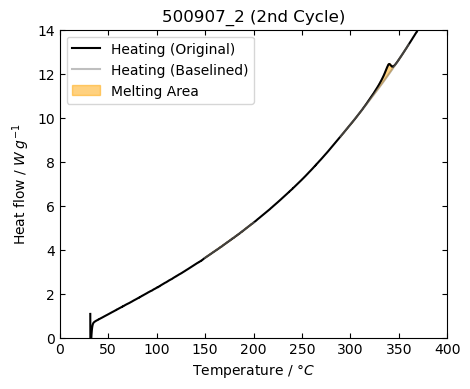

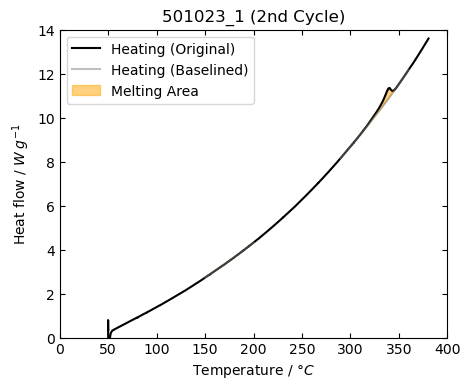

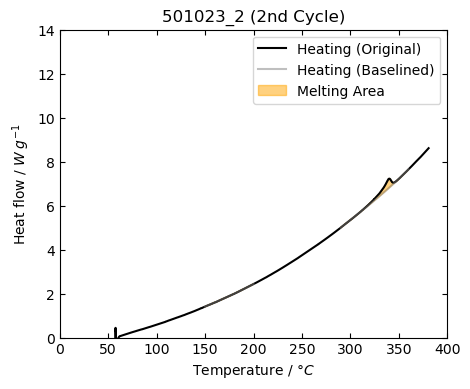

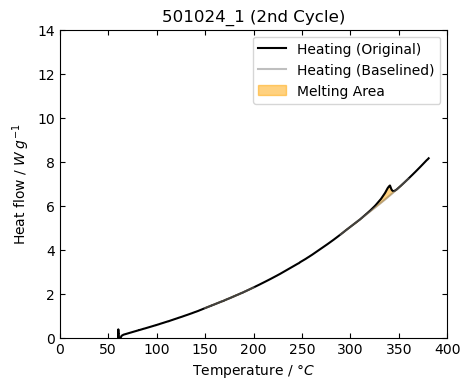

In [36]:
for key, df in data_dict_heating.items():
    # Filter for the 2nd cycle only
    current_cycle_df = df[df['Cycle No'] == 2]  # 2nd cycle
    
    plt.figure(figsize=(5, 4))
    
    for heating_cooling in current_cycle_df['Heating/Cooling/Holding'].unique():
        subset_df = current_cycle_df[current_cycle_df['Heating/Cooling/Holding'] == heating_cooling]
        
        # Plot original heat flow
        plt.plot(subset_df['T / °C'], subset_df['q / W g^-1'], 
                 linestyle=line_styles[heating_cooling], 
                 color='black', 
                 label=f'{heating_cooling} (Original)')
        
        # Plot baselined heat flow
        plt.plot(subset_df['T / °C'], subset_df['q_bl / W g^-1'], 
                 linestyle=line_styles[heating_cooling], 
                 color='gray', 
                 alpha=0.5, 
                 label=f'{heating_cooling} (Baselined)')

        # Shade the area between the baseline and Heat Flow
        plt.fill_between(subset_df['T / °C'], subset_df['q_bl / W g^-1'], subset_df['q / W g^-1'], 
                         alpha=0.5, color='orange', label='Melting Area')
    
    plt.title(f'{key} (2nd Cycle)')
    plt.xlabel(r'Temperature / $°C$')
    plt.ylabel(r'Heat flow / $W \; g^{-1}$')
    # plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlim(0, 400)
    plt.ylim(0, 14)
    plt.legend()
    plt.tick_params(direction='in', top=True, right=True)
    plt.show()


#### Third cycle

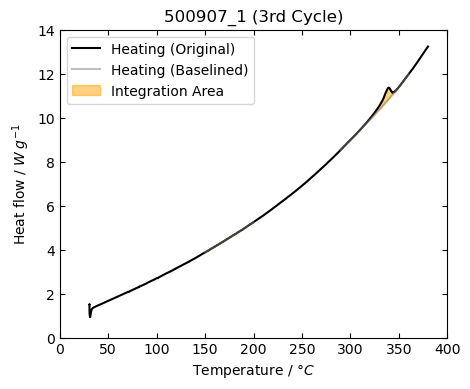

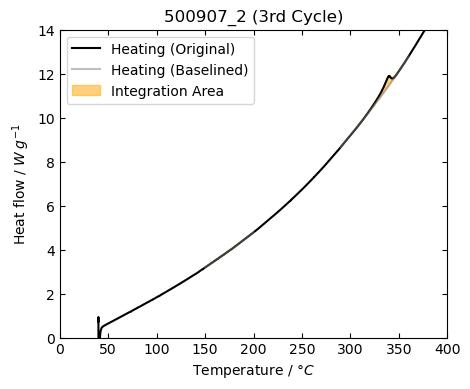

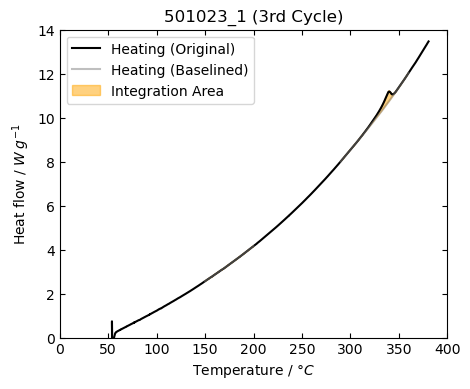

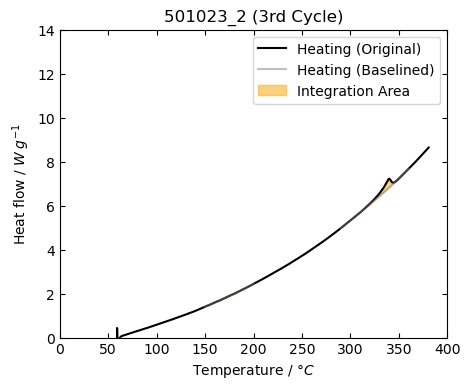

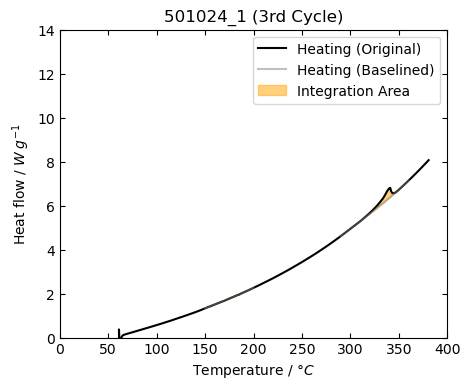

In [37]:
for key, df in data_dict_heating.items():
    # Filter for the 3rd cycle only
    current_cycle_df = df[df['Cycle No'] == 3]  # Third cycle
    
    plt.figure(figsize=(5, 4))
    
    for heating_cooling in current_cycle_df['Heating/Cooling/Holding'].unique():
        subset_df = current_cycle_df[current_cycle_df['Heating/Cooling/Holding'] == heating_cooling]
        
        # Plot original heat flow
        plt.plot(subset_df['T / °C'], subset_df['q / W g^-1'], 
                 linestyle=line_styles[heating_cooling], 
                 color='black', 
                 label=f'{heating_cooling} (Original)')
        
        # Plot baselined heat flow
        plt.plot(subset_df['T / °C'], subset_df['q_bl / W g^-1'], 
                 linestyle=line_styles[heating_cooling], 
                 color='gray', 
                 alpha=0.5, 
                 label=f'{heating_cooling} (Baselined)')

        # Shade the area between the baseline and Heat Flow
        plt.fill_between(subset_df['T / °C'], subset_df['q_bl / W g^-1'], subset_df['q / W g^-1'], 
                         alpha=0.5, color='orange', label='Integration Area')
    
    plt.title(f'{key} (3rd Cycle)')
    plt.xlabel(r'Temperature / $°C$')
    plt.ylabel(r'Heat flow / $W \; g^{-1}$')
    # plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlim(0, 400)
    plt.ylim(0, 14)
    plt.legend()
    plt.tick_params(direction='in', top=True, right=True)
    plt.show()


## Integration

In [38]:
# Calculate melt enthalpy
def calculate_enthalpy(df, temp_range:tuple=(290, 360)):
    # Get data between temp_range
    mask = (df['T / °C'] > temp_range[0]) & (df['T / °C'] < temp_range[1])
    df_calc = df[mask]
    
    # Integrate Heat Flow - baseline with respect to Time
    melt_enthalpy = np.trapz(df_calc['q - q_bl / W g^-1'], df_calc['t / s'])    # [J/g]
    
    return melt_enthalpy, df_calc

In [39]:
# Specify melt enthalpy of 100% crystalline PEEK
melt_enthalpy_cr = 130    # [J/g]

# Create a new DataFrame to store the results
results_df = pd.DataFrame(columns=['sample', 'cycle', 
                                   'melt enthalpy / J g^-1', 
                                   'crystallisation enthalpy / J g^-1', 
                                   'net melt enthalpy / J g^-1', 
                                   'CF / g g^-1'])

# Populate the DataFrame with the results
for key, df in data_dict_heating.items():
    for cycle_no in df['Cycle No'].unique():
        
        # Calculate melt enthalpy
        melt_enthalpy, _ = calculate_enthalpy(df[df['Cycle No'] == cycle_no], temp_range=(290, 360))    # positve value
        
        # Calculate crystallisation enthalpy
        crys_enthalpy, _ = calculate_enthalpy(df[df['Cycle No'] == cycle_no], temp_range=(150, 200))    # negative value
        
        # Calculate net melting enthalpy
        net_melt_enthalpy = melt_enthalpy + crys_enthalpy 
        
        # Calculate CF
        cf = net_melt_enthalpy / melt_enthalpy_cr
        new_row = {'sample': key, 
                   'cycle': cycle_no, 
                   'melt enthalpy / J g^-1': melt_enthalpy, 
                   'crystallisation enthalpy / J g^-1': crys_enthalpy, 
                   'net melt enthalpy / J g^-1': net_melt_enthalpy, 
                   'CF / g g^-1': cf}
        
        results_df.loc[len(results_df)] = new_row

# Display the results DataFrame
print(results_df)

      sample  cycle  melt enthalpy / J g^-1  \
0   500907_1    1.0               46.394067   
1   500907_1    2.0               38.360647   
2   500907_1    3.0               36.732985   
3   500907_2    1.0               36.956485   
4   500907_2    2.0               31.546422   
5   500907_2    3.0               28.966641   
6   501023_1    1.0               36.044072   
7   501023_1    2.0               31.665470   
8   501023_1    3.0               31.407231   
9   501023_2    1.0               31.202189   
10  501023_2    2.0               28.102673   
11  501023_2    3.0               27.350405   
12  501024_1    1.0               37.300732   
13  501024_1    2.0               30.417628   
14  501024_1    3.0               31.211284   

    crystallisation enthalpy / J g^-1  net melt enthalpy / J g^-1  CF / g g^-1  
0                          -20.064896                   26.329171     0.202532  
1                           -0.003373                   38.357274     0.295056  
2   

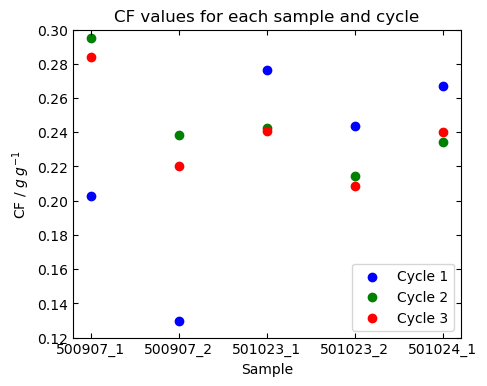

In [40]:
# Plot the CF values
plt.figure(figsize=(5, 4))

# Plot CF values for each cycle with different colors
for cycle_no in results_df['cycle'].unique():
    cycle_df = results_df[results_df['cycle'] == cycle_no]
    plt.scatter(cycle_df['sample'], cycle_df['CF / g g^-1'], 
                marker='o', color=colors[int(cycle_no)], label=f'Cycle {int(cycle_no)}')

plt.xlabel('Sample')
plt.ylabel(r'CF / $g \; g^{-1}$')
plt.title('CF values for each sample and cycle')
plt.ylim(0.12, 0.3)
plt.legend()
plt.tick_params(direction='in', top=True, right=True)
plt.show()